# Introduction to the Low-salt-rejection Reverse Osmosis (LSRRO) Flowsheet
This tutorial shows how to build, initialize, simulate, and optimize an LSRRO flowsheet using WaterTAP.

![alt text](../docs/_static/flowsheets/lsrro.png)

## High-level Preview: Run an LSRRO optimization case. We will specify the following:
* 3-stage system (number_of_stages=3)
* System Water Recovery of 50% (water_recovery=0.50)
* 70 g/L TDS feed (Cin=70) 
* Feed flow rate of 0.001 m3/s (Qin=1e-3)


In [1]:
from watertap.flowsheets.lsrro.lsrro import (
    ACase,
    BCase,
    ABTradeoff,
    run_lsrro_case,
)
import logging
logging.getLogger("idaes").setLevel(logging.ERROR)
logging.getLogger("pyomo").setLevel(logging.ERROR)

In [2]:
m, results = run_lsrro_case(
    number_of_stages=3, # total number of stages
    water_recovery=0.50, # overall water recovery
    Cin=70,  # inlet NaCl conc in kg/m3,
    Qin=1e-3,  # inlet feed flowrate in m3/s
    quick_start=True   # skip rigorous initialization procedure for quick results (increased risk of non-convergence)
)


Feed Concentration = 70.0 ppt

***---Simulation results---***
Simulation failed. The current configuration is infeasible. Please adjust the decision variables.

***---Optimization results---***
----system metrics----
Feed: 1.05 kg/s, 66946 ppm
Product: 0.498 kg/s, 1511 ppm
Brine: 0.548 kg/s, 126470 ppm
Volumetric water recovery: 50.0%
Number of Stages: 3
Total Membrane Area: 319.44
Energy Consumption: 6.3 kWh/m3
Levelized cost of water: 1.54 $/m3
Primary Pump Capital Cost ($/m3):0.4685558390042717
Booster Pump Capital Cost ($/m3): 0.08453309297688603
ERD Capital Cost ($/m3):0.03715961312932659
Membrane Capital Cost ($/m3): 0.16044632535512127
Indirect Capital Cost ($/m3): 0.37534743523280284
Electricity cost ($/m3): 0.44270830493003077


--decision variables--
Stage 1 operating pressure 85.0 bar
Stage 1 membrane area      229.0 m2
Stage 1 water perm. coeff.  1.5 LMH/bar
Stage 1 salt perm. coeff.  0.1 LMH
Stage 2 operating pressure 65.0 bar
Stage 2 membrane area      89.5 m2
Stage 2 wat

## Overview of setting up and optimizing the LSRRO flowsheet--step by step.
* Step 0: Import Python libraries.
* Step 1: Build the LSRRO flowsheet.
* Step 2: Set specifications for LSRRO flowsheet.
* Step 3: Initialize the LSRRO flowsheet.
* Step 4: Optimize the LSRRO flowsheet.
* Step 5: Visualize results.

## Step 0: Import libraries.

In [3]:
# Import LSRRO flowsheet module
from watertap.flowsheets.lsrro import lsrro

## Step 1: Build the LSRRO flowsheet.

In [4]:
# Create a Pyomo concrete model, flowsheet, and NaCl property parameter block.
m = lsrro.build(
    number_of_stages=3,
    has_NaCl_solubility_limit=True,
    has_calculated_concentration_polarization=True,
    has_calculated_ro_pressure_drop=True,
    number_of_RO_finite_elements=10,

)


## Step 2: Set specifications for the LSRRO flowsheet.

In [5]:
lsrro.set_operating_conditions(m)

Feed Concentration = 70.0 ppt


## Step 3: Initialize the LSRRO flowsheet model.

In [6]:
lsrro.initialize(m)

--------------------START FORWARD INITIALIZATION PASS--------------------
--------------------START BACKWARD INITIALIZATION PASS--------------------
--------------------START FORWARD INITIALIZATION PASS--------------------
INFO: Starting Sequential Decomposition
INFO: Starting first pass run of network
2025-09-12 14:56:10 [INFO] idaes.init.fs.feed: Initialization Complete.
2025-09-12 14:56:11 [INFO] idaes.init.fs.PrimaryPumps[1].control_volume: Initialization Complete
2025-09-12 14:56:11 [INFO] idaes.init.fs.PrimaryPumps[1]: Initialization Complete: optimal - Optimal Solution Found
2025-09-12 14:56:11 [INFO] idaes.init.fs.Mixers[1]: Initialization Complete: optimal - Optimal Solution Found
2025-09-12 14:56:11 [INFO] idaes.init.fs.ROUnits[1].feed_side: Initialization Complete
2025-09-12 14:56:13 [INFO] idaes.init.fs.ROUnits[1]: Initialization Complete: optimal - Optimal Solution Found
2025-09-12 14:56:13 [INFO] idaes.init.fs.EnergyRecoveryDevices[1].control_volume: Initialization Comple

## Step 4: Simulate the LSRRO flowsheet.

In [7]:
lsrro.solve(m, tee=False)
print("Simulation Results:\n")
lsrro.display_system(m)

Simulation Results:

----system metrics----
Feed: 1.05 kg/s, 66946 ppm
Product: 0.349 kg/s, 751 ppm
Brine: 0.697 kg/s, 100084 ppm
Volumetric water recovery: 35.0%
Number of Stages: 3
Total Membrane Area: 183.33
Energy Consumption: 10.4 kWh/m3
Levelized cost of water: 2.41 $/m3
Primary Pump Capital Cost ($/m3):0.8290266209380903
Booster Pump Capital Cost ($/m3): 0.16734617929012008
ERD Capital Cost ($/m3):0.06539992139610248
Membrane Capital Cost ($/m3): 0.14403584004108508
Indirect Capital Cost ($/m3): 0.6029042808326991
Electricity cost ($/m3): 0.7309236776200411




## Step 5: Optimize the LSRRO flowsheet.

In [8]:
lsrro.optimize_set_up(m,
    water_recovery=0.5,
    A_case=ACase.optimize, # water permeability coefficient
    B_case=BCase.optimize, # salt permeability coefficient
    AB_tradeoff=ABTradeoff.equality_constraint, # water and salt permeability equality constraints
    permeate_quality_limit=500e-6,
    )
optimization_results = lsrro.solve(m, raise_on_failure=True) 

In [9]:
print("Optimization Results:\n")
lsrro.display_system(m)

Optimization Results:

----system metrics----
Feed: 1.05 kg/s, 66946 ppm
Product: 0.498 kg/s, 500 ppm
Brine: 0.548 kg/s, 127301 ppm
Volumetric water recovery: 50.0%
Number of Stages: 3
Total Membrane Area: 242.69
Energy Consumption: 9.0 kWh/m3
Levelized cost of water: 1.94 $/m3
Primary Pump Capital Cost ($/m3):0.5508102736918976
Booster Pump Capital Cost ($/m3): 0.18165719719739787
ERD Capital Cost ($/m3):0.04458632368629701
Membrane Capital Cost ($/m3): 0.1469527167064308
Indirect Capital Cost ($/m3): 0.46200325564101163
Electricity cost ($/m3): 0.6276017013441124




## 

## Step 6: Visualize results

In [10]:
from watertap.flowsheets.lsrro.multi_sweep import _lsrro_presweep as setup_sensitivity_sweep
from parameter_sweep import LinearSample, parameter_sweep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def feed_concentration_recovery_profile(m,number_of_stages, points_per_sweep=5):
    """
    Generate a cost-optimal feed concentration vs recovery profile for a given number of stages.
    Args:

        points_per_sweep (int): Number of points to sample in the sweep.
        number_of_stages (int): Number of RO stages in the system.
    Returns:
        results (pd.DataFrame): DataFrame containing the sweep results.
        output_filename (str): Path to the CSV file where results are saved.
        fig, ax: Matplotlib figure and axis objects for the contour plot.
    """
    output_filename = f"param_sweep_output/{number_of_stages}_stage/results_LSRRO.csv"
    sweep_params = {}
    outputs = {}
    nx = points_per_sweep
    if m is None:
        m = setup_sensitivity_sweep(number_of_stages=number_of_stages)
    else:
        if (m.fs.NumberOfStages == number_of_stages) or (m.fs.NumberOfStages is None):
            pass
        else:
            raise ValueError("Model already exists with a different number of stages. Please pass None as the model argument to create a new model, or pass None as the number_of_stages argument.")
    m.fs.feed.flow_mass_phase_comp.unfix()
    m.fs.feed.properties[0].conc_mass_phase_comp["Liq", "NaCl"].fix()
    m.fs.feed.properties[0].flow_vol_phase["Liq"].fix()
    # Sweep parameters ------------------------------------------------------------------------

    sweep_params["Feed Concentration"] = LinearSample(m.fs.feed.properties[0].conc_mass_phase_comp["Liq", "NaCl"], 70, 150, nx)

    sweep_params["Volumetric Recovery Rate"] = LinearSample(m.fs.water_recovery, 0.2, 0.65, nx)

    # Outputs  -------------------------------------------------------------------------------
    outputs["LCOW"] = m.fs.costing.LCOW
    outputs["LCOW wrt Feed Flow"] = m.fs.costing.LCOW_feed
    outputs["SEC"] = m.fs.costing.specific_energy_consumption
    outputs["SEC wrt Feed"] = m.fs.costing.specific_energy_consumption_feed

    sweep_sensitivity_results = parameter_sweep(
            m,
            sweep_params,
            outputs,
            csv_results_file_name=output_filename,
            optimize_function=lsrro.solve,
            interpolate_nan_outputs=True,
        )
    results= pd.read_csv(output_filename)

    fig, ax = plt.subplots(1,1, figsize=(8, 12), dpi=300)

    X, Y = np.meshgrid(np.unique(results["# Feed Concentration"].to_numpy()), np.unique(results["Volumetric Recovery Rate"].to_numpy()))

    Z = results["LCOW"].to_numpy().reshape(X.shape)

    cbar = ax.contourf(X,Y,Z,cmap="jet")

    ax.set_xlabel("Feed Concentration (kg/m3)")
    ax.set_ylabel("Volumetric Recovery Rate (%)")

    cbar = fig.colorbar(cbar, ax=ax)
    cbar.set_label("LCOW ($/m3)")
    ax.set_title(f"{number_of_stages}-Stage System");
    contours = ax.contour(X,Y,Z, colors="k")

    ax.clabel(contours)


    return results, output_filename, fig, ax


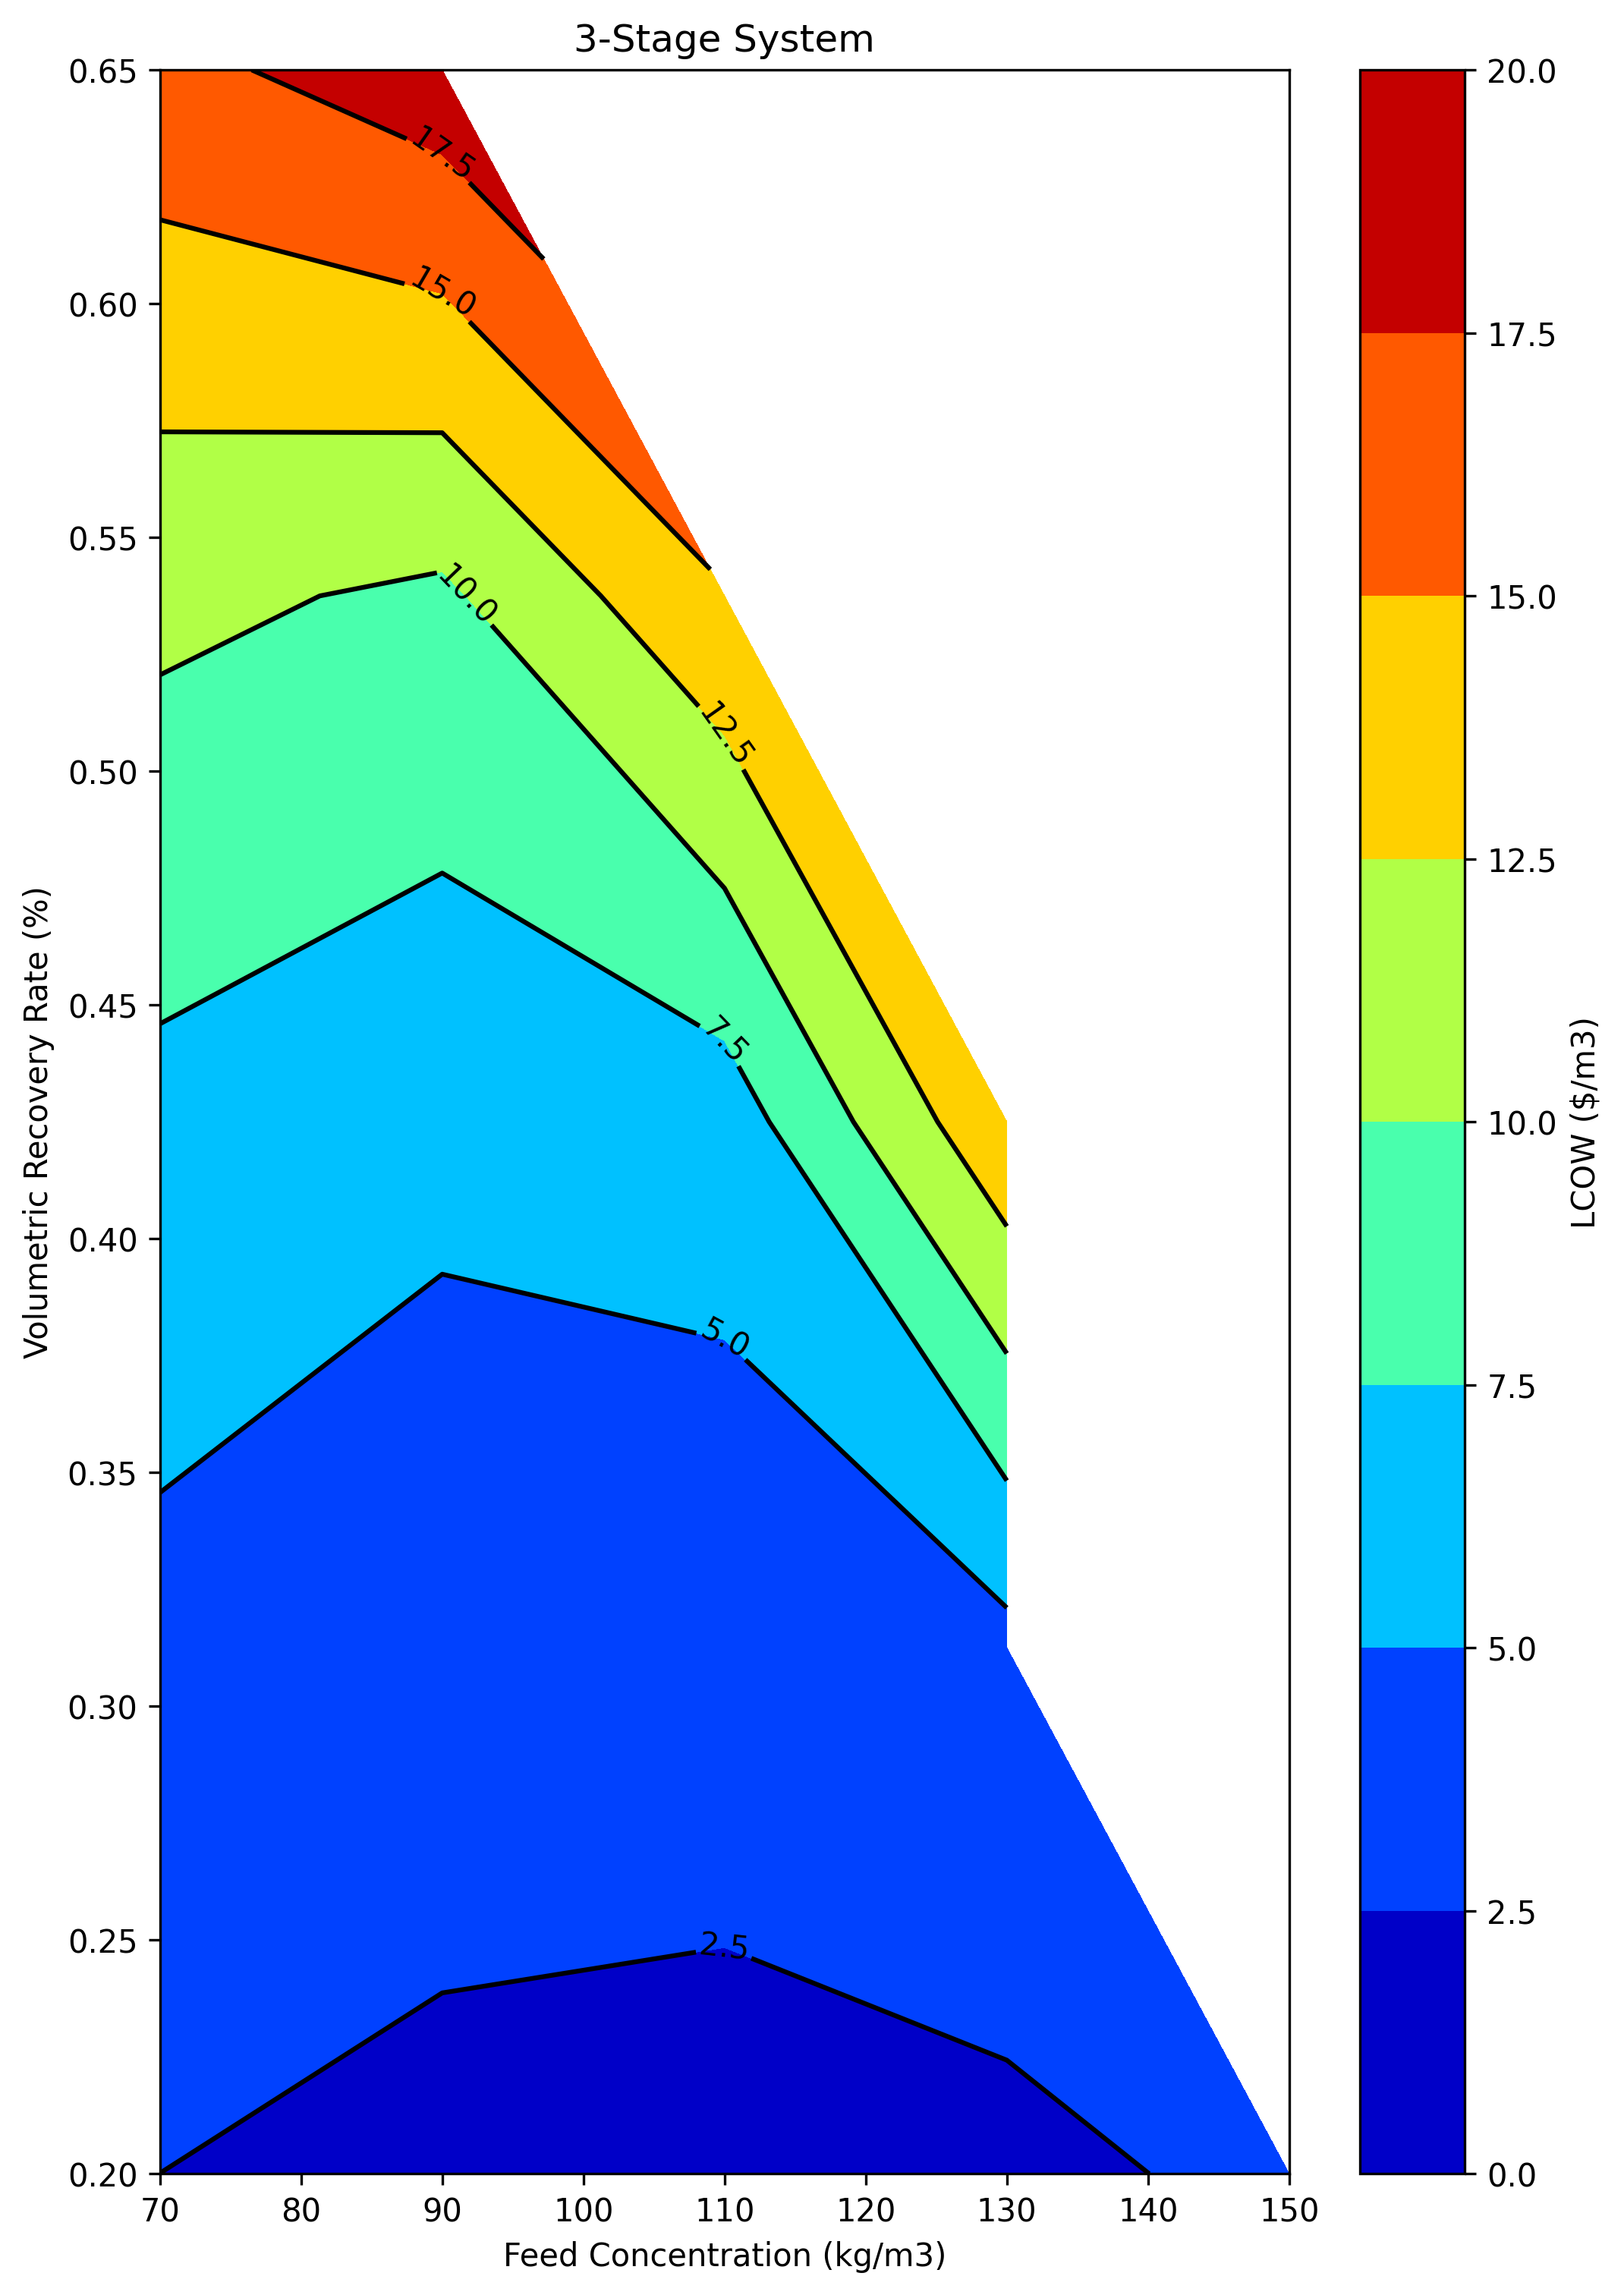

In [11]:
results3, _, fig3, ax3 = feed_concentration_recovery_profile(m=m,number_of_stages=3, points_per_sweep=5)

Feed Concentration = 70.0 ppt
--------------------START FORWARD INITIALIZATION PASS--------------------
--------------------START BACKWARD INITIALIZATION PASS--------------------
--------------------START FORWARD INITIALIZATION PASS--------------------
--------------------START BACKWARD INITIALIZATION PASS--------------------
--------------------START FORWARD INITIALIZATION PASS--------------------
INFO: Starting Sequential Decomposition
INFO: Starting first pass run of network
2025-09-12 15:04:27 [INFO] idaes.init.fs.feed: Initialization Complete.
2025-09-12 15:04:27 [INFO] idaes.init.fs.PrimaryPumps[1].control_volume: Initialization Complete
2025-09-12 15:04:27 [INFO] idaes.init.fs.PrimaryPumps[1]: Initialization Complete: optimal - Optimal Solution Found
2025-09-12 15:04:27 [INFO] idaes.init.fs.Mixers[1]: Initialization Complete: optimal - Optimal Solution Found
2025-09-12 15:04:27 [INFO] idaes.init.fs.ROUnits[1].feed_side: Initialization Complete
2025-09-12 15:04:29 [INFO] idaes.in

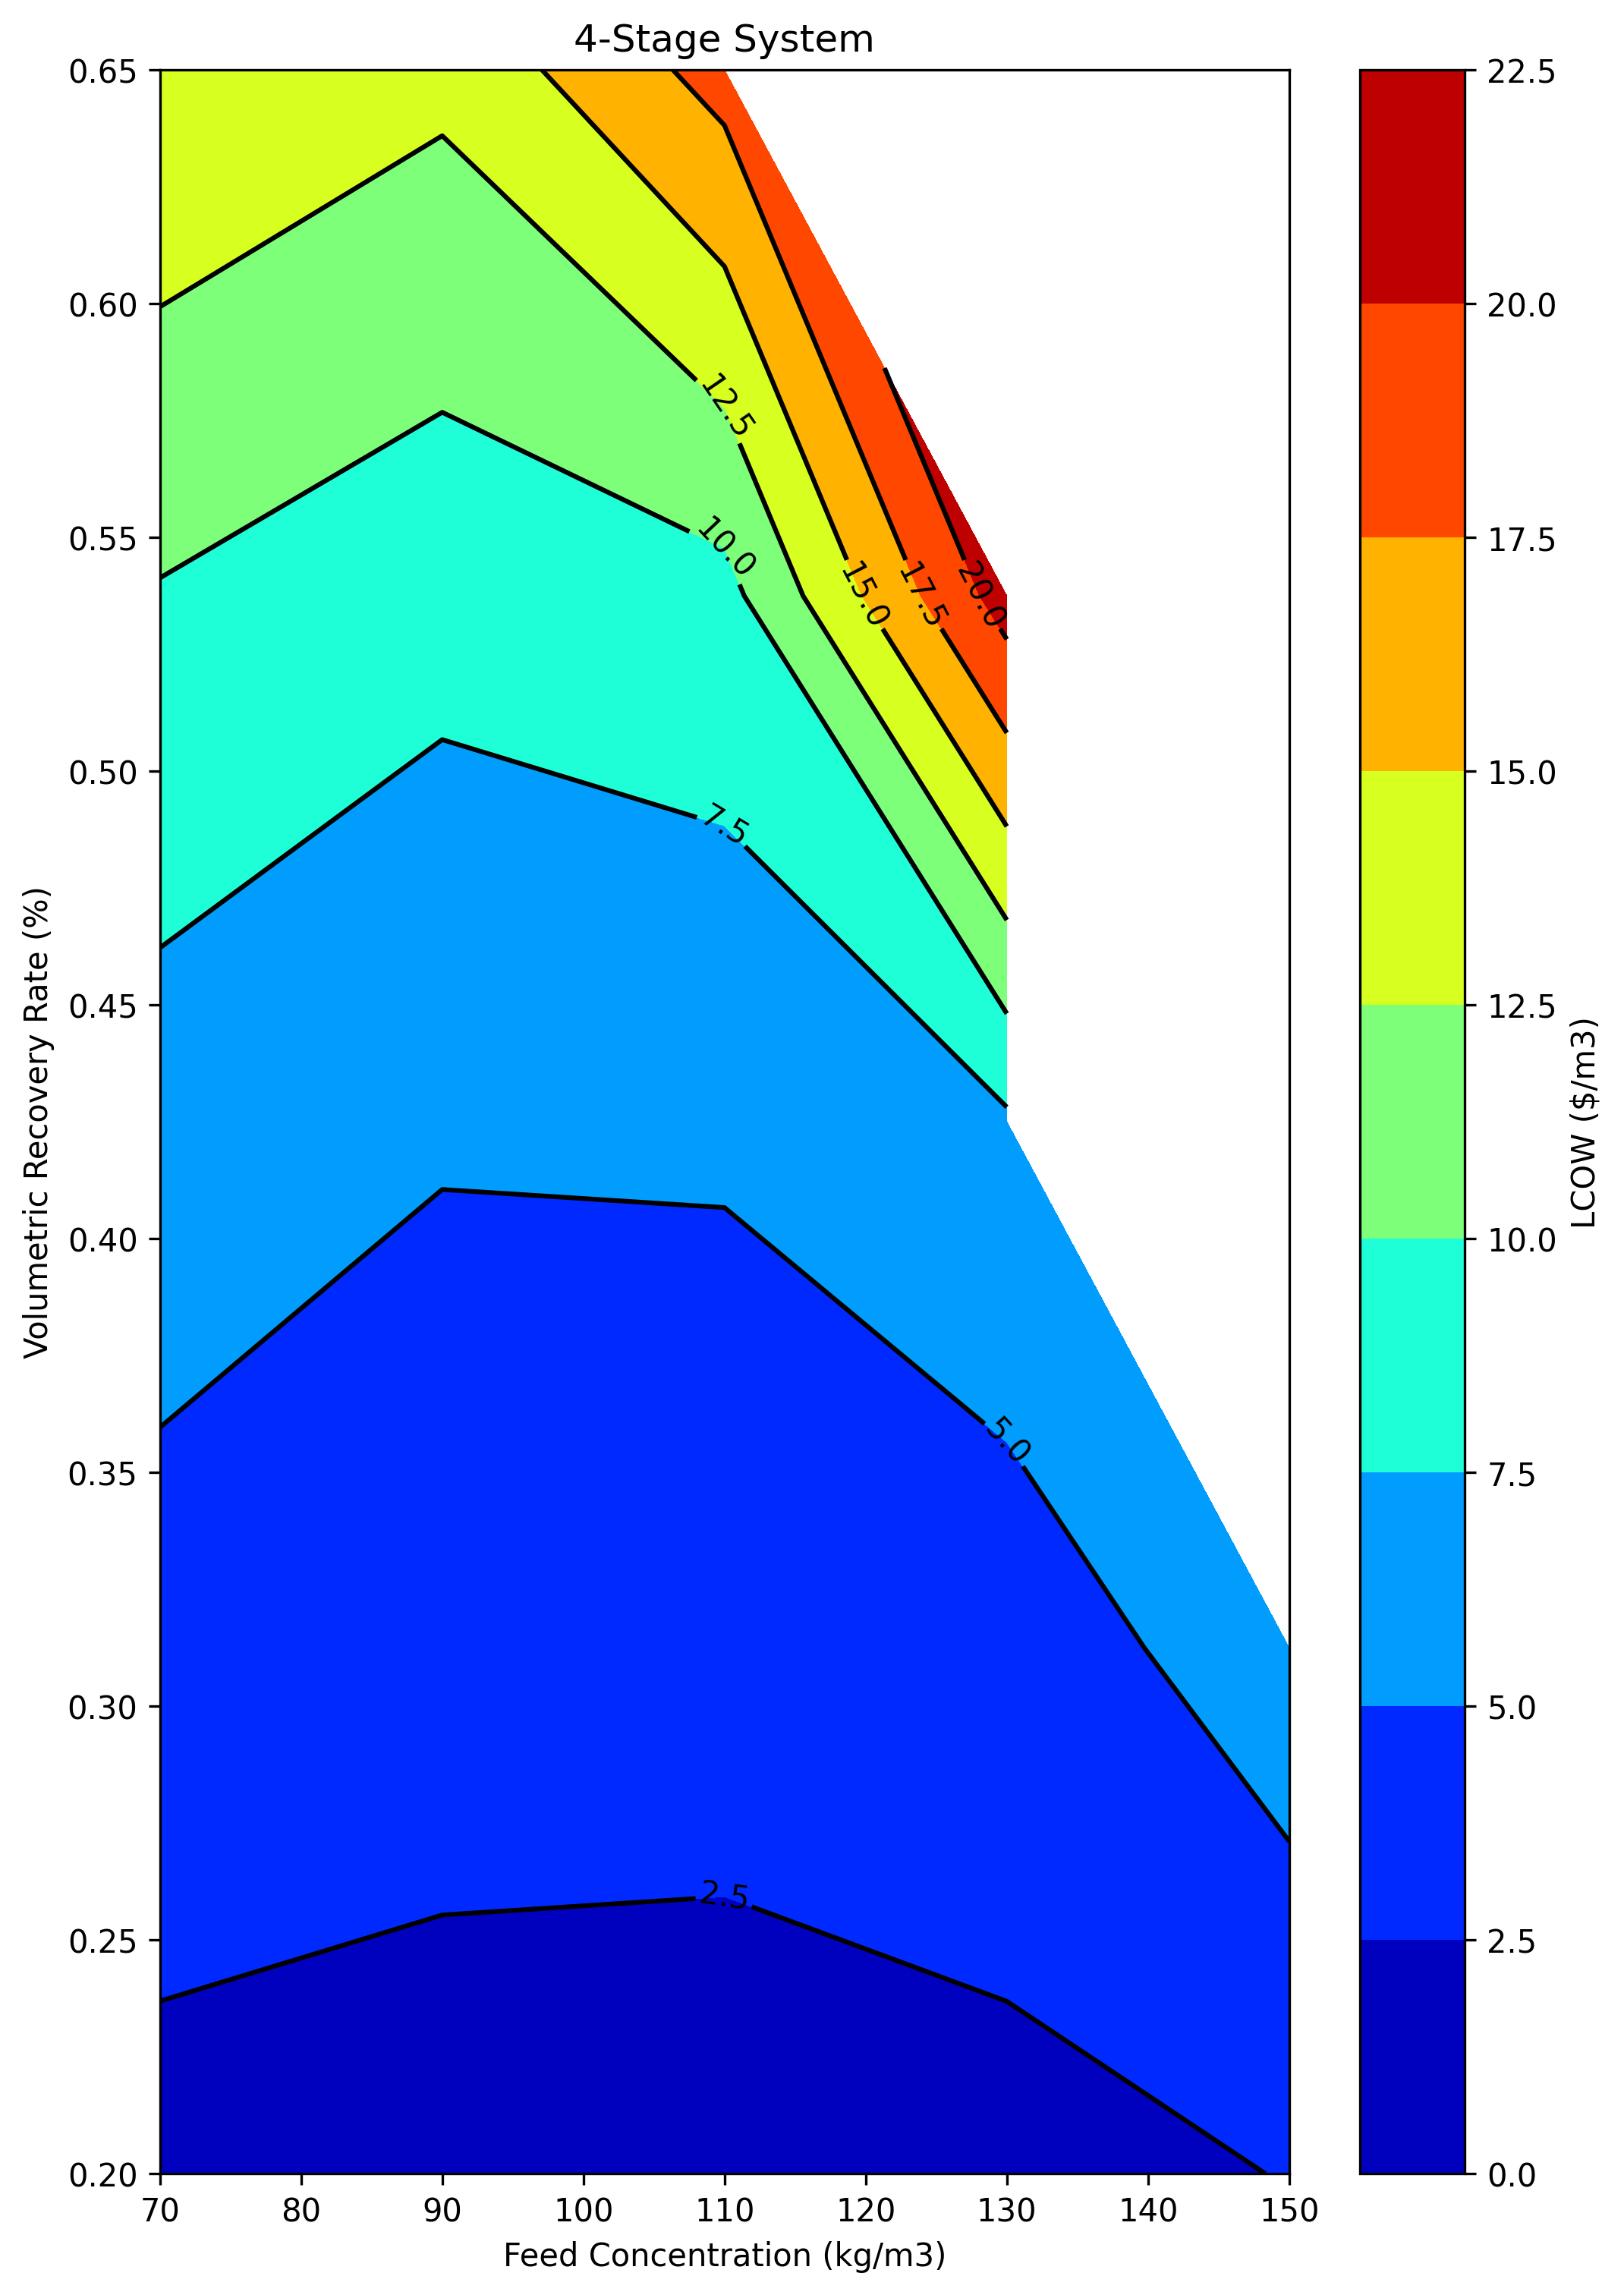

In [12]:
results4, _, fig4, ax4 = feed_concentration_recovery_profile(None,number_of_stages=4, points_per_sweep=5)

In [13]:
# TODO: Show bar plots for stage-wise results and possibly LCOW breakdown for 3 and 4 stage cases